In [ ]:
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import os
import multiprocessing as mp
from tqdm import tqdm
from scipy.signal import detrend
from scipy.stats import linregress

from matplotlib import rcParams
from matplotlib.ticker import MaxNLocator
import matplotlib.dates as mdates
from scipy.stats import linregress
import warnings

rcParams['font.family'] = 'Inter'
rcParams['font.size'] = 12
rcParams['figure.figsize'] = [5.0, 5.0]
rcParams['figure.dpi'] = 300
rcParams['xtick.direction'] = 'in'
rcParams['ytick.direction'] = 'in'

In [ ]:
def get_file_list(product_dir):
    filelist=[]
    for file in sorted(os.listdir(product_dir)):
        filelist.append(os.path.join(product_dir, file))
    return filelist

MODIS_LCSIF_DIR="../../data/MODIS_LCSIF_v3"
MODIS_LCREF_DIR="../../data/MODIS_LCREF_v3"
LCSIF_v31_DIR="../../data/LCSIF_v3.1/"
LCREF_v31_DIR="../../data/LCREF_v3.1/"
LTDR_LCSIF = "../../data/LTDR_LCSIF/"
LTDR_LCREF = "../../data/LTDR_LCREF/"


LCSIF_v31_LIST=[f for f in get_file_list(LCSIF_v31_DIR) if "SNOW" in f]
LCREF_v31_LIST=[f for f in get_file_list(LCREF_v31_DIR) if "SNOW" in f]
LTDR_LCSIF_LIST = get_file_list(LTDR_LCSIF)
LTDR_LCREF_LIST = get_file_list(LTDR_LCREF)


MODIS_LCSIF_FILE_LIST=[f for f in get_file_list(MODIS_LCSIF_DIR) if "SNOW" in f]
MODIS_LCREF_FILE_LIST=[f for f in get_file_list(MODIS_LCREF_DIR) if "SNOW" in f]

LCSIF_v31_PRE_2001_PERIOD_FILE_LIST=LCSIF_v31_LIST[0:19*24]
LCSIF_v31_POST_2001_PERIOD_FILE_LIST=LCSIF_v31_LIST[19*24:]

LCREF_v31_PRE_2001_PERIOD_FILE_LIST=LCREF_v31_LIST[0:19*24]
LCREF_v31_POST_2001_PERIOD_FILE_LIST=LCREF_v31_LIST[19*24:]


LTDR_LCSIF_PRE_2001_PERIOD_FILE_LIST=LTDR_LCSIF_LIST[0:19*24]
LTDR_LCSIF_POST_2001_PERIOD_FILE_LIST=LTDR_LCSIF_LIST[19*24:]

PICS=pd.read_csv(os.path.join("../../data/", "PICS.csv"))


In [3]:
def extract_sif_pics_site(file_list):
    pics_sif_list=[]
    for file in file_list:
        ds=xr.open_dataset(file).sif_clear_daily
        pics_sif_list.append(np.diag(ds.sel(lat=PICS.lat.values, lon=PICS.lon.values, method="nearest")[0].values))
        ds.close()
    return pics_sif_list

def extract_nir_pics_site(file_list):
    pics_nir_list=[]
    for file in file_list:
        ds=xr.open_dataset(file).nir
        pics_nir_list.append(np.diag(ds.sel(lat=PICS.lat.values, lon=PICS.lon.values, method="nearest")[0].values))
        ds.close()
    return pics_nir_list

def extract_red_pics_site(file_list):
    pics_red_list=[]
    for file in file_list:
        ds=xr.open_dataset(file).red
        pics_red_list.append(np.diag(ds.sel(lat=PICS.lat.values, lon=PICS.lon.values, method="nearest")[0].values))
        ds.close()
    return pics_red_list

In [4]:

RED_AVHRR = extract_red_pics_site(LCREF_v31_LIST)
RED_MODIS = extract_red_pics_site(MODIS_LCREF_FILE_LIST)
RED_LTDR = extract_red_pics_site(LTDR_LCREF_LIST)

NIR_AVHRR = extract_nir_pics_site(LCREF_v31_LIST)
NIR_MODIS = extract_nir_pics_site(MODIS_LCREF_FILE_LIST)
NIR_LTDR = extract_nir_pics_site(LTDR_LCREF_LIST)


RED_AVHRR_MATRIX = np.vstack(RED_AVHRR)
RED_MODIS_MATRIX = np.vstack(RED_MODIS)
RED_LTDR_MATRIX = np.vstack(RED_LTDR)

NIR_AVHRR_MATRIX = np.vstack(NIR_AVHRR)
NIR_MODIS_MATRIX = np.vstack(NIR_MODIS)
NIR_LTDR_MATRIX = np.vstack(NIR_LTDR)


In [5]:
LCSIF_AVHRR= extract_sif_pics_site(LCSIF_v31_LIST)
LCSIF_MODIS = extract_sif_pics_site(MODIS_LCSIF_FILE_LIST)
LCSIF_LTDR = extract_sif_pics_site(LTDR_LCSIF_LIST)


LCSIF_AVHRR_MATRIX = np.vstack(LCSIF_AVHRR)
LCSIF_MODIS_MATRIX = np.vstack(LCSIF_MODIS)
LCSIF_LTDR_MATRIX = np.vstack(LCSIF_MODIS)

In [6]:
fig_dir = "./figs"

In [ ]:
RED_AVHRR_MATRIX_mvc=np.zeros((np.int64(RED_AVHRR_MATRIX.shape[0]/2), RED_AVHRR_MATRIX.shape[1]))
for i in range(int(RED_AVHRR_MATRIX.shape[0]/2)):
    RED_AVHRR_MATRIX_mvc[i, :] = np.nanmax(RED_AVHRR_MATRIX[2*i:2*i+2, :], axis=0)
RED_AVHRR_MATRIX_mvc_year=np.zeros((np.int64(RED_AVHRR_MATRIX_mvc.shape[0] /12), RED_AVHRR_MATRIX_mvc.shape[1]))
for i in range(int(RED_AVHRR_MATRIX_mvc_year.shape[0])):
    RED_AVHRR_MATRIX_mvc_year[i, :] = np.nanmean(RED_AVHRR_MATRIX_mvc[12*i:12*i+12, :], axis=0)

RED_AVHRR_MATRIX_mvc_year_normalized=RED_AVHRR_MATRIX_mvc_year/np.mean(RED_AVHRR_MATRIX_mvc_year, axis=0)
RED_AVHRR_MATRIX_mvc_normalized=RED_AVHRR_MATRIX_mvc/np.mean(RED_AVHRR_MATRIX_mvc, axis=0)

In [ ]:
RED_MODIS_MATRIX_mvc=np.zeros((np.int64(RED_MODIS_MATRIX.shape[0]/2), RED_MODIS_MATRIX.shape[1]))
for i in range(int(RED_MODIS_MATRIX.shape[0]/2)):
    RED_MODIS_MATRIX_mvc[i, :] = np.nanmax(RED_MODIS_MATRIX[2*i:2*i+2, :], axis=0)
RED_MODIS_MATRIX_mvc_year=np.zeros((np.int64(RED_MODIS_MATRIX_mvc.shape[0] /12), RED_MODIS_MATRIX_mvc.shape[1]))
for i in range(int(RED_MODIS_MATRIX_mvc_year.shape[0])):
    RED_MODIS_MATRIX_mvc_year[i, :] = np.nanmean(RED_MODIS_MATRIX_mvc[12*i:12*i+12, :], axis=0)

RED_MODIS_MATRIX_mvc_year_normalized=RED_MODIS_MATRIX_mvc_year/np.mean(RED_MODIS_MATRIX_mvc_year, axis=0)
RED_MODIS_MATRIX_mvc_normalized=RED_MODIS_MATRIX_mvc/np.mean(RED_MODIS_MATRIX_mvc, axis=0)

In [ ]:
NIR_AVHRR_MATRIX_mvc=np.zeros((np.int64(NIR_AVHRR_MATRIX.shape[0]/2), NIR_AVHRR_MATRIX.shape[1]))
for i in range(int(NIR_AVHRR_MATRIX.shape[0]/2)):
    NIR_AVHRR_MATRIX_mvc[i, :] = np.nanmax(NIR_AVHRR_MATRIX[2*i:2*i+2, :], axis=0)
NIR_AVHRR_MATRIX_mvc_year=np.zeros((np.int64(NIR_AVHRR_MATRIX_mvc.shape[0] /12), NIR_AVHRR_MATRIX_mvc.shape[1]))
for i in range(int(NIR_AVHRR_MATRIX_mvc_year.shape[0])):
    NIR_AVHRR_MATRIX_mvc_year[i, :] = np.nanmean(NIR_AVHRR_MATRIX_mvc[12*i:12*i+12, :], axis=0)

NIR_AVHRR_MATRIX_mvc_year_normalized=NIR_AVHRR_MATRIX_mvc_year/np.mean(NIR_AVHRR_MATRIX_mvc_year, axis=0)
NIR_AVHRR_MATRIX_mvc_normalized=NIR_AVHRR_MATRIX_mvc/np.mean(NIR_AVHRR_MATRIX_mvc, axis=0)

In [ ]:
NIR_MODIS_MATRIX_mvc=np.zeros((np.int64(NIR_MODIS_MATRIX.shape[0]/2), NIR_MODIS_MATRIX.shape[1]))
for i in range(int(NIR_MODIS_MATRIX.shape[0]/2)):
    NIR_MODIS_MATRIX_mvc[i, :] = np.nanmax(NIR_MODIS_MATRIX[2*i:2*i+2, :], axis=0)
NIR_MODIS_MATRIX_mvc_year=np.zeros((np.int64(NIR_MODIS_MATRIX_mvc.shape[0] /12), NIR_MODIS_MATRIX_mvc.shape[1]))
for i in range(int(NIR_MODIS_MATRIX_mvc_year.shape[0])):
    NIR_MODIS_MATRIX_mvc_year[i, :] = np.nanmean(NIR_MODIS_MATRIX_mvc[12*i:12*i+12, :], axis=0)

NIR_MODIS_MATRIX_mvc_year_normalized=NIR_MODIS_MATRIX_mvc_year/np.mean(NIR_MODIS_MATRIX_mvc_year, axis=0)
NIR_MODIS_MATRIX_mvc_normalized=NIR_MODIS_MATRIX_mvc/np.mean(NIR_MODIS_MATRIX_mvc, axis=0)

In [ ]:
LCSIF_AVHRR_MATRIX_mvc=np.zeros((np.int64(LCSIF_AVHRR_MATRIX.shape[0]/2), LCSIF_AVHRR_MATRIX.shape[1]))
for i in range(int(LCSIF_AVHRR_MATRIX.shape[0]/2)):
    LCSIF_AVHRR_MATRIX_mvc[i, :] = np.nanmax(LCSIF_AVHRR_MATRIX[2*i:2*i+2, :], axis=0)
LCSIF_AVHRR_MATRIX_mvc_year=np.zeros((np.int64(LCSIF_AVHRR_MATRIX_mvc.shape[0] /12), LCSIF_AVHRR_MATRIX_mvc.shape[1]))
for i in range(int(LCSIF_AVHRR_MATRIX_mvc_year.shape[0])):
    LCSIF_AVHRR_MATRIX_mvc_year[i, :] = np.nanmean(LCSIF_AVHRR_MATRIX_mvc[12*i:12*i+12, :], axis=0)

LCSIF_AVHRR_MATRIX_mvc_year_normalized=LCSIF_AVHRR_MATRIX_mvc_year/np.mean(LCSIF_AVHRR_MATRIX_mvc_year, axis=0)
LCSIF_AVHRR_MATRIX_mvc_normalized=LCSIF_AVHRR_MATRIX_mvc/np.mean(LCSIF_AVHRR_MATRIX_mvc, axis=0)

In [ ]:
LCSIF_MODIS_MATRIX_mvc=np.zeros((np.int64(LCSIF_MODIS_MATRIX.shape[0]/2), LCSIF_MODIS_MATRIX.shape[1]))
for i in range(int(LCSIF_MODIS_MATRIX.shape[0]/2)):
    LCSIF_MODIS_MATRIX_mvc[i, :] = np.nanmax(LCSIF_MODIS_MATRIX[2*i:2*i+2, :], axis=0)
LCSIF_MODIS_MATRIX_mvc_year=np.zeros((np.int64(LCSIF_MODIS_MATRIX_mvc.shape[0] /12), LCSIF_MODIS_MATRIX_mvc.shape[1]))
for i in range(int(LCSIF_MODIS_MATRIX_mvc_year.shape[0])):
    LCSIF_MODIS_MATRIX_mvc_year[i, :] = np.nanmean(LCSIF_MODIS_MATRIX_mvc[12*i:12*i+12, :], axis=0)

LCSIF_MODIS_MATRIX_mvc_year_normalized=LCSIF_MODIS_MATRIX_mvc_year/np.mean(LCSIF_MODIS_MATRIX_mvc_year, axis=0)
LCSIF_MODIS_MATRIX_mvc_normalized=LCSIF_MODIS_MATRIX_mvc/np.mean(LCSIF_MODIS_MATRIX_mvc, axis=0)

In [55]:
area_weight=xr.open_dataset(os.path.join("../../data/", "CMG_0.05Degree_Area_WGS84.nc")).area.values

NAN_MASK = xr.open_dataset("../../data/processed/LCSIF_LCREF_MASK.nc").LCSIF_LCREF_MASK.values
growing_season_flag = np.invert(np.load("../../data/growing_season_monthly_flag.npy"))

In [17]:
def compute_annual_mean_from_biweekly(file_list, var_name="sif_clear_daily"):
    annual_mean_list=[]
    with warnings.catch_warnings():
        warnings.filterwarnings('ignore', r'All-NaN (slice|axis) encountered')
        warnings.filterwarnings('ignore', r'Mean of empty (slice|axis)')
        for YEAR in tqdm(np.array(file_list).reshape(-1,24)):
            year_list=[]
            for i in range(12):
                first_half_month = xr.open_dataset(YEAR[i*2])[var_name].values[0]
                first_half_month[NAN_MASK]=np.nan
                second_half_month = xr.open_dataset(YEAR[i*2 + 1])[var_name].values[0]  
                second_half_month[NAN_MASK]=np.nan
                mvc = np.nanmax(np.stack([first_half_month, second_half_month]), axis=0)
                mvc[growing_season_flag[i, :, :]] = np.nan
                monthly_mean = np.nansum(mvc * area_weight) / np.nansum(area_weight[np.invert(np.isnan(mvc * area_weight))])
                year_list.append(monthly_mean)
            annual_mean_list.append(np.nanmean(year_list))
        return np.array(annual_mean_list)

In [18]:
lcsif_avhrr_weighted_spatial_annual_mean_list=compute_annual_mean_from_biweekly(LCSIF_v31_LIST)
lcsif_modis_weighted_spatial_annual_mean_list=compute_annual_mean_from_biweekly(MODIS_LCSIF_FILE_LIST)
lcsif_ltdr_weighted_spatial_annual_mean_list=compute_annual_mean_from_biweekly(LTDR_LCSIF_LIST)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 41/41 [20:48<00:00, 30.44s/it]


In [56]:
val_idx = np.load("../../data/pics_val_idx.npy")
NIR_AVHRR_MATRIX_mvc_year=NIR_AVHRR_MATRIX_mvc_year[:, val_idx]
RED_AVHRR_MATRIX_mvc_year=RED_AVHRR_MATRIX_mvc_year[:, val_idx]
NIR_MODIS_MATRIX_mvc_year=NIR_MODIS_MATRIX_mvc_year[:, val_idx]
RED_MODIS_MATRIX_mvc_year=RED_MODIS_MATRIX_mvc_year[:, val_idx]

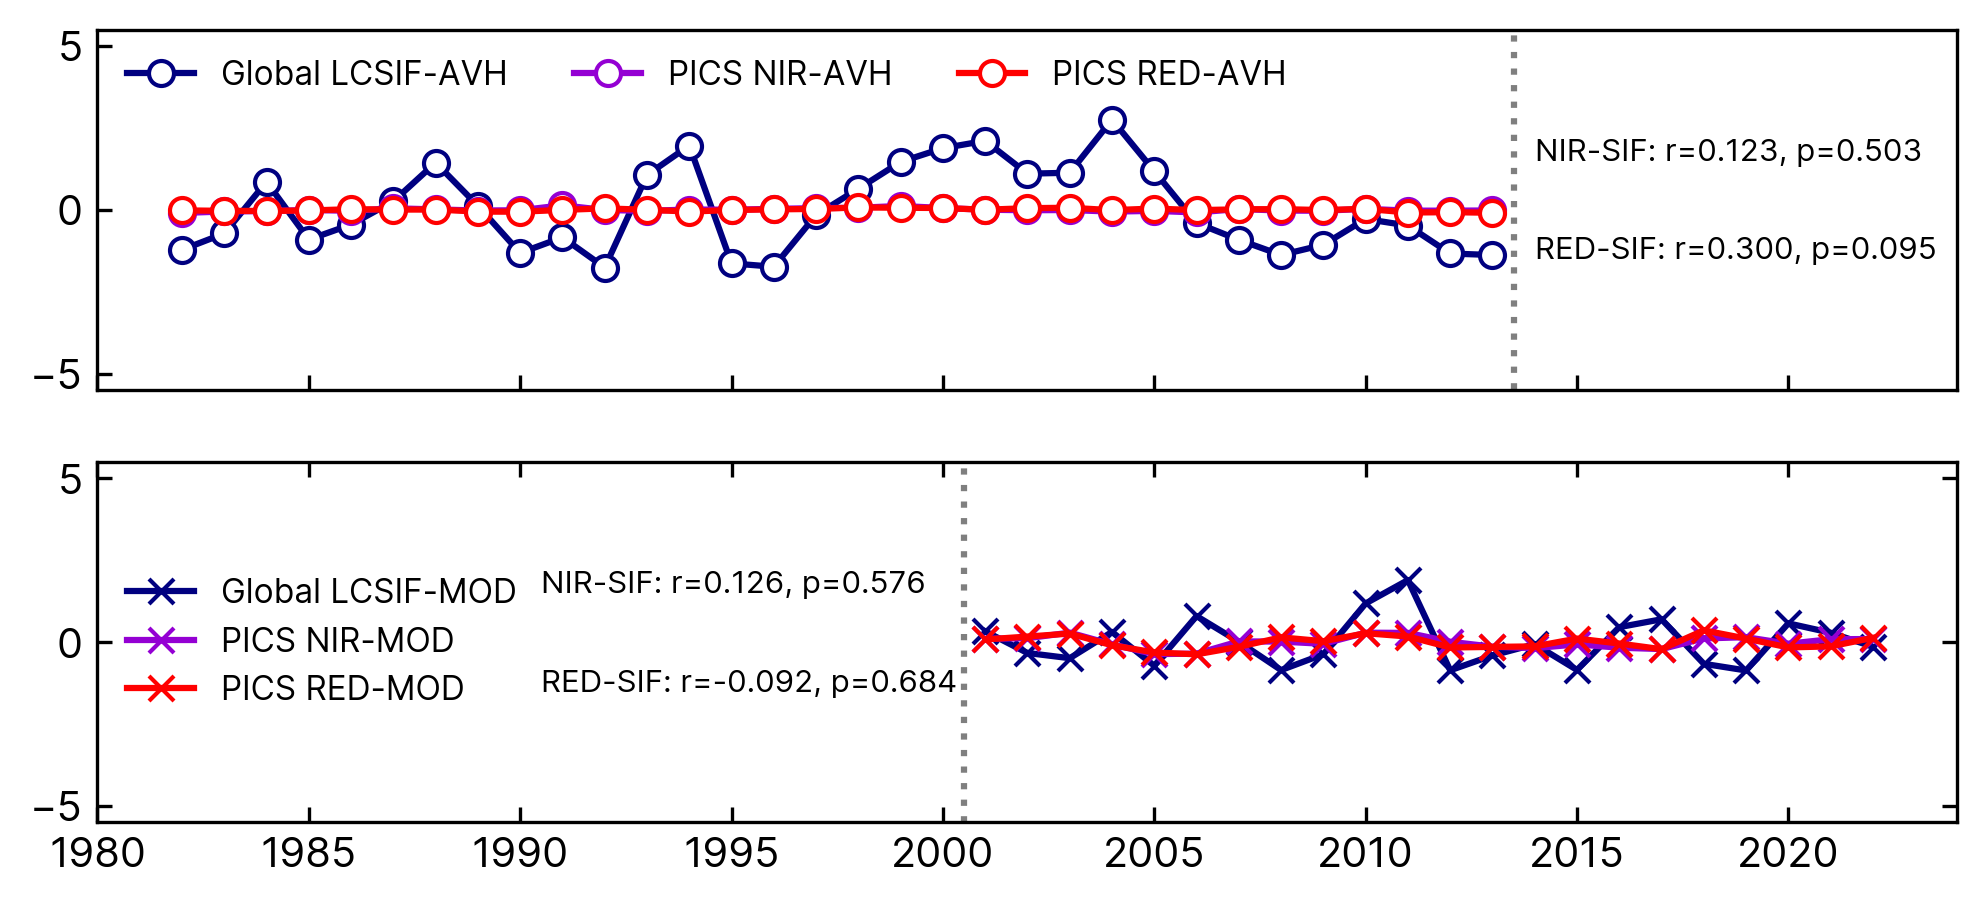

In [67]:
fig, axs = plt.subplots(2, 1, figsize=(8,3.5), sharex=True, dpi=300)
ax=axs.flatten()

NIR_AVHRR_MATRIX_mvc_year_normalized = NIR_AVHRR_MATRIX_mvc_year[:-9, :] / np.mean(NIR_AVHRR_MATRIX_mvc_year[:-9, :], axis=0)
RED_AVHRR_MATRIX_mvc_year_normalized = RED_AVHRR_MATRIX_mvc_year[:-9, :] / np.mean(RED_AVHRR_MATRIX_mvc_year[:-9, :], axis=0)

NIR_METOP_MATRIX_mvc_year_normalized = NIR_AVHRR_MATRIX_mvc_year[-9:, :] / np.mean(NIR_AVHRR_MATRIX_mvc_year[-9:, :], axis=0)
RED_METOP_MATRIX_mvc_year_normalized = RED_AVHRR_MATRIX_mvc_year[-9:, :] / np.mean(RED_AVHRR_MATRIX_mvc_year[-9:, :], axis=0)

NIR_MODIS_MATRIX_mvc_year_normalized = NIR_MODIS_MATRIX_mvc_year / np.mean(NIR_MODIS_MATRIX_mvc_year, axis=0)
RED_MODIS_MATRIX_mvc_year_normalized = RED_MODIS_MATRIX_mvc_year / np.mean(RED_MODIS_MATRIX_mvc_year, axis=0)


NIR_AVHRR_detrend=detrend(np.median(NIR_AVHRR_MATRIX_mvc_year_normalized, axis=1))
RED_AVHRR_detrend=detrend(np.median(RED_AVHRR_MATRIX_mvc_year_normalized, axis=1))
lcsif_avhrr_detrend=detrend(lcsif_avhrr_weighted_spatial_annual_mean_list[:-9]/np.mean(lcsif_avhrr_weighted_spatial_annual_mean_list[:-9]))
lcsif_metop_detrend=detrend(lcsif_avhrr_weighted_spatial_annual_mean_list[-9:]/np.mean(lcsif_avhrr_weighted_spatial_annual_mean_list[-9:]))

NIR_MODIS_detrend=detrend(np.median(NIR_MODIS_MATRIX_mvc_year_normalized, axis=1))
RED_MODIS_detrend=detrend(np.median(RED_MODIS_MATRIX_mvc_year_normalized, axis=1))
lcsif_modis_detrend=detrend(lcsif_modis_weighted_spatial_annual_mean_list/np.mean(lcsif_modis_weighted_spatial_annual_mean_list))

line1, = ax[0].plot(np.arange(1982,2014), lcsif_avhrr_detrend * 100, "-o", markerfacecolor="white",  c="navy", label="Global LCSIF-AVH")
line2, = ax[0].plot(np.arange(1982,2014), NIR_AVHRR_detrend * 100 , "-o", markerfacecolor="white", c="darkviolet", label= "PICS NIR-AVH")
line3, = ax[0].plot(np.arange(1982,2014), RED_AVHRR_detrend * 100 , "-o", markerfacecolor="white", c="red", label="PICS RED-AVH")

line4, = ax[1].plot(np.arange(2001,2023), lcsif_modis_detrend * 100, "-x", markerfacecolor="white", c="navy", label="Global LCSIF-MOD")
line5, = ax[1].plot(np.arange(2001,2023), NIR_MODIS_detrend * 100 , "-x", markerfacecolor="white", c="darkviolet", label= "PICS NIR-MOD")
line6, = ax[1].plot(np.arange(2001,2023), RED_MODIS_detrend * 100 , "-x", markerfacecolor="white", c="red", label="PICS RED-MOD")

ax[0].plot([2013.5, 2013.5], [-6, 6], "k:", alpha=0.5)
ax[1].plot([2000.5, 2000.5], [-6, 6], "k:", alpha=0.5)
reg_sif_nir_avhrr = linregress(lcsif_avhrr_detrend, NIR_AVHRR_detrend)
reg_sif_red_avhrr = linregress(lcsif_avhrr_detrend, RED_AVHRR_detrend)

reg_sif_nir_modis = linregress(lcsif_modis_detrend, NIR_MODIS_detrend)
reg_sif_red_modis = linregress(lcsif_modis_detrend, RED_MODIS_detrend)

ax[0].text(2014, 1.5, "NIR-SIF: r={:.3f}, p={:.3f}".format(reg_sif_nir_avhrr.rvalue, reg_sif_nir_avhrr.pvalue), fontsize=7.5)
ax[0].text(2014, -1.5, "RED-SIF: r={:.3f}, p={:.3f}".format(reg_sif_red_avhrr.rvalue, reg_sif_red_avhrr.pvalue), fontsize=7.5)

ax[1].text(1990.5, 1.5, "NIR-SIF: r={:.3f}, p={:.3f}".format(reg_sif_nir_modis.rvalue, reg_sif_nir_modis.pvalue), fontsize=7.5)
ax[1].text(1990.5, -1.5, "RED-SIF: r={:.3f}, p={:.3f}".format(reg_sif_red_modis.rvalue, reg_sif_red_modis.pvalue), fontsize=7.5)

ax[0].set_ylim(-5.5, 5.5)

ax[1].set_ylim(-5.5, 5.5)
#plt.text("Detrended Normalized Anomalies (%)")
plt.tick_params(right=True, top=True)

ax[0].legend(handles=[line1, line2, line3], ncol=3, loc="upper left", frameon=False, fontsize=8)

ax[1].legend(handles=[line4, line5, line6], ncol=1, loc="center left", frameon=False, fontsize=8)

#plt.savefig(os.path.join(fig_dir, "PICSNIR_GLOBALLCSIF_Detrended_Normalzied_Bias_nan_mean.pdf"))